# Multi-Branch Networks  (GoogLeNet)
:label:`sec_googlenet`

In 2014, *GoogLeNet*
won the ImageNet Challenge :cite:`Szegedy.Liu.Jia.ea.2015`, using a structure
that combined the strengths of NiN :cite:`Lin.Chen.Yan.2013`, repeated blocks :cite:`Simonyan.Zisserman.2014`,
and a cocktail of convolution kernels. It was arguably also the first network that exhibited a clear distinction among the stem (data ingest), body (data processing), and head (prediction) in a CNN. This design pattern has persisted ever since in the design of deep networks: the *stem* is given by the first two or three convolutions that operate on the image. They extract low-level features from the underlying images. This is followed by a *body* of convolutional blocks. Finally, the *head* maps the features obtained so far to the required classification, segmentation, detection, or tracking problem at hand.

The key contribution in GoogLeNet was the design of the network body. It solved the problem of selecting
convolution kernels in an ingenious way. While other works tried to identify which convolution, ranging from $1 \times 1$ to $11 \times 11$ would be best, it simply *concatenated* multi-branch convolutions.
In what follows we introduce a slightly simplified version of GoogLeNet: the original design included a number of tricks for stabilizing training through intermediate loss functions, applied to multiple layers of the network. 
They are no longer necessary due to the availability of improved training algorithms.

In [22]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using CUDA, cuDNN

  Activating project at `/workspace/d2l-julia/d2lai`


## **Inception Blocks**

The basic convolutional block in GoogLeNet is called an *Inception block*,
stemming from the meme "we need to go deeper" from the movie *Inception*.

![Structure of the Inception block.](../img/inception.svg)
:label:`fig_inception`

As depicted in :numref:`fig_inception`,
the inception block consists of four parallel branches.
The first three branches use convolutional layers
with window sizes of $1\times 1$, $3\times 3$, and $5\times 5$
to extract information from different spatial sizes.
The middle two branches also add a $1\times 1$ convolution of the input
to reduce the number of channels, reducing the model's complexity.
The fourth branch uses a $3\times 3$ max-pooling layer,
followed by a $1\times 1$ convolutional layer
to change the number of channels.
The four branches all use appropriate padding to give the input and output the same height and width.
Finally, the outputs along each branch are concatenated
along the channel dimension and comprise the block's output.
The commonly-tuned hyperparameters of the Inception block
are the number of output channels per layer, i.e., how to allocate capacity among convolutions of different size.


In [49]:
struct InceptionBlock{N1, N2, N3, N4} <: AbstractModel 
    net1::N1
    net2::N2
    net3::N3 
    net4::N4
end 

function InceptionBlock(channel_in::Int, channel1::Int, channel2::Tuple, channel3::Tuple, channel4::Int)
    net1 = Chain(
        Conv((1,1), channel_in => channel1, relu)
    )

    net2 = Chain(
        Conv((1,1), channel_in => channel2[1], relu),
        Conv((3,3), channel2[1] => channel2[2], relu, pad = 1)
    )

    net3 = Chain(
        Conv((1,1), channel_in => channel3[1], relu),
        Conv((5,5), channel3[1] => channel3[2], relu, pad = 2)
    )

    net4 = Chain(
        MaxPool((3,3), pad = 1, stride = 1),
        Conv((1,1), channel_in => channel4)
    )
    InceptionBlock(net1, net2, net3, net4)
end

function (ib::InceptionBlock)(x)
    n1 = ib.net1(x)
    n2 = ib.net2(x)
    n3 = ib.net3(x)
    n4 = ib.net4(x)
    cat(n1, n2, n3, n4; dims = 3)
end

Flux.@layer InceptionBlock


To gain some intuition for why this network works so well,
consider the combination of the filters.
They explore the image in a variety of filter sizes.
This means that details at different extents
can be recognized efficiently by filters of different sizes.
At the same time, we can allocate different amounts of parameters
for different filters.


## **GoogLeNet Model**

As shown in :numref:`fig_inception_full`, GoogLeNet uses a stack of a total of 9 inception blocks, arranged into three groups with max-pooling in between,
and global average pooling in its head to generate its estimates.
Max-pooling between inception blocks reduces the dimensionality.
At its stem, the first module is similar to AlexNet and LeNet.

![The GoogLeNet architecture.](../img/inception-full-90.svg)
:label:`fig_inception_full`

We can now implement GoogLeNet piece by piece. Let's begin with the stem.
The first module uses a 64-channel $7\times 7$ convolutional layer.


In [26]:
function b1(channel_in = 1)
        Chain(
        Conv((7,7), channel_in => 64, pad = 3, stride = 2),
        MaxPool((3,3), stride = 2, pad = 1),        
    )
end

b1 (generic function with 2 methods)

The second module uses two convolutional layers:
first, a 64-channel $1\times 1$ convolutional layer,
followed by a $3\times 3$ convolutional layer that triples the number of channels. This corresponds to the second branch in the Inception block and concludes the design of the body. At this point we have 192 channels.


In [35]:
function b2(channel_in = 64)
    Chain(
        Conv((1,1), channel_in => 64, relu),
        Conv((3,3), 64 => 192, relu),
        MaxPool((3,3), pad = 1, stride = 2)
        
    )
end

b2 (generic function with 2 methods)

The third module connects two complete Inception blocks in series.
The number of output channels of the first Inception block is
$64+128+32+32=256$. This amounts to 
a ratio of the number of output channels
among the four branches of $2:4:1:1$. To achieve this, we first reduce the input
dimensions by $\frac{1}{2}$ and by $\frac{1}{12}$ in the second and third branch respectively
to arrive at $96 = 192/2$ and $16 = 192/12$ channels respectively.

The number of output channels of the second Inception block
is increased to $128+192+96+64=480$, yielding a ratio of $128:192:96:64 = 4:6:3:2$. As before,
we need to reduce the number of intermediate dimensions in the second and third channel. A
scale of $\frac{1}{2}$ and $\frac{1}{8}$ respectively suffices, yielding $128$ and $32$ channels
respectively. This is captured by the arguments of the following `Inception` block constructors.


In [37]:
function b3(channel_in = 192)
    Chain(
        InceptionBlock(channel_in, 64, (96, 128), (16, 32), 32),
        InceptionBlock(256, 128, (128, 192), (32, 96), 64),
        MaxPool((3,3), stride = 2, pad = 1),
    )
end

b3 (generic function with 2 methods)

The fourth module is more complicated.
It connects five Inception blocks in series,
and they have $192+208+48+64=512$, $160+224+64+64=512$,
$128+256+64+64=512$, $112+288+64+64=528$,
and $256+320+128+128=832$ output channels, respectively.
The number of channels assigned to these branches is similar
to that in the third module:
the second branch with the $3\times 3$ convolutional layer
outputs the largest number of channels,
followed by the first branch with only the $1\times 1$ convolutional layer,
the third branch with the $5\times 5$ convolutional layer,
and the fourth branch with the $3\times 3$ max-pooling layer.
The second and third branches will first reduce
the number of channels according to the ratio.
These ratios are slightly different in different Inception blocks.

In [47]:
function b4(channel_in = 480)
    Chain(
        InceptionBlock(channel_in, 192, (96, 208), (16, 48), 64),
        InceptionBlock(512, 160, (112, 224), (24, 64), 64),
        InceptionBlock(512, 128, (128, 256), (24, 64), 64),
        InceptionBlock(512, 112, (144, 288), (32, 64), 64),
        InceptionBlock(528, 256, (160, 320), (32, 128), 128),
        MaxPool((3,3), stride = 2, pad = 1)
    )
end

b4 (generic function with 2 methods)

The fifth module has two Inception blocks with $256+320+128+128=832$
and $384+384+128+128=1024$ output channels.
The number of channels assigned to each branch
is the same as that in the third and fourth modules,
but differs in specific values.
It should be noted that the fifth block is followed by the output layer.
This block uses the global average pooling layer
to change the height and width of each channel to 1, just as in NiN.
Finally, we turn the output into a two-dimensional array
followed by a fully connected layer
whose number of outputs is the number of label classes.

In [39]:
function b5(channel_in = 832)
    Chain(
        InceptionBlock(channel_in, 256, (160, 320), (32, 128), 128),
        InceptionBlock(832, 384, (192, 384), (48, 128), 128),
        GlobalMeanPool(),
        Flux.flatten,
    )
end

b5 (generic function with 2 methods)

In [54]:
struct GoogLeNet{N} <: AbstractClassifier 
    net::N 
end

function GoogLeNet(num_classes::Int = 10)
    net = Flux.@autosize (96, 96, 1, 1) Chain(
        b1(),
        b2(),
        b3(),
        b4(),
        b5(),
        Dense(_ => num_classes),
        softmax
    )
    GoogLeNet(net)
end

Flux.@layer GoogLeNet 

(gn::GoogLeNet)(x) = gn.net(x)

In [52]:
model = GoogLeNet()
model.net

Chain(
  Chain(
    Conv((7, 7), 1 => 64, pad=3, stride=2),  # 3_200 parameters
    MaxPool((3, 3), pad=1, stride=2),
  ),
  Chain(
    Conv((1, 1), 64 => 64, relu),       # 4_160 parameters
    Conv((3, 3), 64 => 192, relu),      # 110_784 parameters
    MaxPool((3, 3), pad=1, stride=2),
  ),
  Chain(
    InceptionBlock(
      Chain(
        Conv((1, 1), 192 => 64, relu),  # 12_352 parameters
      ),
      Chain(
        Conv((1, 1), 192 => 96, relu),  # 18_528 parameters
        Conv((3, 3), 96 => 128, relu, pad=1),  # 110_720 parameters
      ),
      Chain(
        Conv((1, 1), 192 => 16, relu),  # 3_088 parameters
        Conv((5, 5), 16 => 32, relu, pad=2),  # 12_832 parameters
      ),
      Chain(
        MaxPool((3, 3), pad=1, stride=1),
        Conv((1, 1), 192 => 32),        # 6_176 parameters
      ),
    ),
    InceptionBlock(
      Chain(
        Conv((1, 1), 256 => 128, relu),  # 32_896 parameters
      ),
      Chain(
        Conv((1, 1), 256 => 128, relu),  # 32_896 p

[ Info: Train Loss: 1.9313097, Val Loss: 1.971195, Val Acc: 0.5
[ Info: Train Loss: 0.6317029, Val Loss: 0.5401543, Val Acc: 0.75
[ Info: Train Loss: 0.350438, Val Loss: 0.3720257, Val Acc: 0.8125
[ Info: Train Loss: 0.41230914, Val Loss: 0.45135814, Val Acc: 0.8125
[ Info: Train Loss: 0.48061773, Val Loss: 0.36486176, Val Acc: 0.875
[ Info: Train Loss: 0.41049662, Val Loss: 0.47697634, Val Acc: 0.8125
[ Info: Train Loss: 0.24872112, Val Loss: 0.38211867, Val Acc: 0.8125
[ Info: Train Loss: 0.4497632, Val Loss: 0.4631205, Val Acc: 0.8125
[ Info: Train Loss: 0.3283075, Val Loss: 0.43611112, Val Acc: 0.75
[ Info: Train Loss: 0.37559816, Val Loss: 0.2629991, Val Acc: 0.8125
[ Info: Train Loss: 0.27002808, Val Loss: 0.274528, Val Acc: 0.9375
[ Info: Train Loss: 0.17974333, Val Loss: 0.4215269, Val Acc: 0.75
[ Info: Train Loss: 0.31861034, Val Loss: 0.3670521, Val Acc: 0.75
[ Info: Train Loss: 0.3217962, Val Loss: 0.35750878, Val Acc: 0.75
[ Info: Train Loss: 0.18585555, Val Loss: 0.3029928

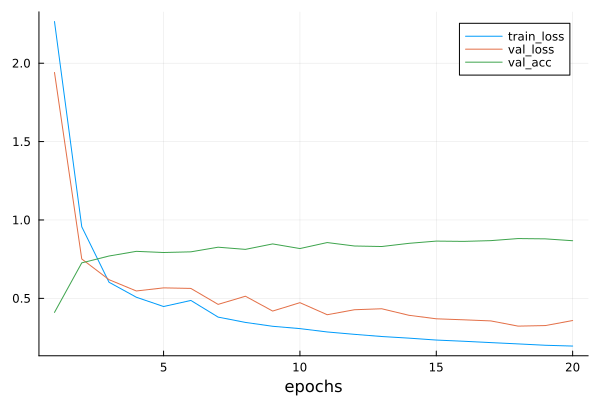

In [56]:
data = d2lai.FashionMNISTData(batchsize = 128, resize = (96, 96))
opt = Descent(0.01)
trainer = Trainer(model, data, opt; max_epochs = 20, gpu = true, board_yscale = :identity)
d2lai.fit(trainer);

## Discussion

A key feature of GoogLeNet is that it is actually *cheaper* to compute than its predecessors
while simultaneously providing improved accuracy. This marks the beginning of a much more deliberate
network design that trades off the cost of evaluating a network with a reduction in errors. It also marks the beginning of experimentation at a block level with network design hyperparameters, even though it was entirely manual at the time. We will revisit this topic in :numref:`sec_cnn-design` when discussing strategies for network structure exploration. 

Over the following sections we will encounter a number of design choices (e.g., batch normalization, residual connections, and channel grouping) that allow us to improve networks significantly. For now, you can be proud to have implemented what is arguably the first truly modern CNN.

## Exercises

1. GoogLeNet was so successful that it went through a number of iterations, progressively improving speed and accuracy. Try to implement and run some of them. They include the following:
    1. Add a batch normalization layer :cite:`Ioffe.Szegedy.2015`, as described later in :numref:`sec_batch_norm`.
    1. Make adjustments to the Inception block (width, choice and order of convolutions), as described in :citet:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
    1. Use label smoothing for model regularization, as described in :citet:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
    1. Make further adjustments to the Inception block by adding residual connection :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017`, as described later in :numref:`sec_resnet`.
1. What is the minimum image size needed for GoogLeNet to work?
1. Can you design a variant of GoogLeNet that works on Fashion-MNIST's native resolution of $28 \times 28$ pixels? How would you need to change the stem, the body, and the head of the network, if anything at all?
1. Compare the model parameter sizes of AlexNet, VGG, NiN, and GoogLeNet. How do the latter two network
   architectures significantly reduce the model parameter size?
1. Compare the amount of computation needed in GoogLeNet and AlexNet. How does this affect the design of an accelerator chip, e.g., in terms of memory size, memory bandwidth, cache size, the amount of computation, and the benefit of specialized operations?

### 1.

In [181]:
function InceptionBlockFactorized1(channel_in::Int, channel1::Int, channel2::Tuple, channel3::Tuple, channel4::Int, reduce = false)
    r = reduce ? 2 : 1
    net1 = Chain(
        Conv((1,1), channel_in => channel1, relu, stride = r)
    )

    net2 = Chain(
        Conv((1,1), channel_in => channel2[1], relu),
        Conv((3,3), channel2[1] => channel2[2], relu, pad = 1, stride = r)
    )

    net3 = Chain(
        Conv((1,1), channel_in => channel3[1], relu),
        Conv((3,3), channel3[1] => channel3[2], relu, pad = 1, stride = 1),
        Conv((3,3), channel3[2] => channel3[3], relu, pad = 1, stride = r)
    )

    net4 = Chain(
        MaxPool((3,3), pad = 1, stride = r),
        Conv((1,1), channel_in => channel4)
    )
    InceptionBlock(net1, net2, net3, net4)
end

function InceptionBlockFactorized2(channel_in::Int, channel1::Int, channel2::Tuple, channel3::Tuple, channel4::Int, reduce = false)
    r = reduce ? 2 : 1
    net1 = Chain(
        Conv((1,1), channel_in => channel1, relu, stride = r)
    )

    net2 = Chain(
        Conv((1,1), channel_in => channel2[1], relu),
        Conv((1,7), channel2[1] => channel2[1], relu, pad = (0,3), stride = 1),
        Conv((7,1), channel2[1] => channel2[2], relu, pad = (3,0), stride = r),
    )

    net3 = Chain(
        Conv((1,7), channel_in => channel3[1], relu, pad = (0,3), stride = 1),
        Conv((7,1), channel3[1] => channel3[2], relu, pad = (3,0), stride = 1),
        Conv((1,7), channel3[2] => channel3[3], relu, pad = (0,3), stride = 1),
        Conv((7,1), channel3[3] => channel3[4], relu, pad = (3,0), stride = r),
    )

    net4 = Chain(
        MaxPool((3,3), pad = 1, stride = r),
        Conv((1,1), channel_in => channel4)
    )
    InceptionBlock(net1, net2, net3, net4)
end

function InceptionBlockFactorized3(channel_in::Int, channel1::Int, channel2::Tuple, channel3::Tuple, channel4::Int, reduce = false)
    r = reduce ? 2 : 1

    net1 = Chain(
        Conv((1,1), channel_in => channel1, relu, stride = r)
    )

    net2 = Chain(
        Conv((1,1), channel_in => channel2[1], relu),
        Conv((3,3), channel2[1] => channel2[2], relu, pad = 1, stride = 1),
        Parallel(
            (x,y)->cat(x,y, dims = 3),
            Conv((1, 3), channel2[2] => channel2[3], relu, pad = (0, 1), stride = r),    
            Conv((3, 1), channel2[2] => channel2[3], relu, pad = (1, 0), stride = r)
        )
    )

    net3 = Chain(
        Conv((1,1), channel_in => channel3[2], relu),
        Parallel(
            (x,y)->cat(x,y, dims = 3),
            Conv((1, 3), channel3[2] => channel3[3], relu, pad = (0, 1), stride = r),    
            Conv((3, 1), channel3[2] => channel3[3], relu, pad = (1, 0), stride = r)
        )
    )

    net4 = Chain(
        MaxPool((3,3), pad = 1, stride = r),
        Conv((1,1), channel_in => channel4)
    )
    InceptionBlock(net1, net2, net3, net4)
end

InceptionBlockFactorized3 (generic function with 3 methods)

In [281]:
struct GoogLeNetFactorized{N} <: AbstractClassifier 
    net::N
end

function GoogLeNetFactorized(num_classes::Int = 10)
    net = Flux.@autosize (150, 150, 1, 1) Chain(
        Conv((3,3), 1 => 16, stride = 2),
        Conv((3,3), 16 => 16, stride = 1),
        Conv((3,3), 16 => 32, stride = 1, pad =1 ),
        
        MaxPool((3,3), stride = 2),
        
        Conv((3,3), 32 => 40, stride = 1),
        Conv((3,3), 40 => 96, stride = 2),
        Conv((3,3), 96 => 144, stride = 1),

        InceptionBlockFactorized1(144, 64, (16, 64), (16, 64, 96), 64),
        InceptionBlockFactorized1(288, 64, (16, 64), (16, 64, 96), 64),
        InceptionBlockFactorized1(288, 64, (16, 64), (16, 64, 96), 64, true),

        InceptionBlockFactorized2(288, 128, (64, 128), (64, 96, 128, 256), 128),
        InceptionBlockFactorized2(640, 128, (64, 128), (64, 96, 128, 256), 128),
        InceptionBlockFactorized2(640, 128, (64, 128), (64, 96, 128, 256), 128),
        InceptionBlockFactorized2(640, 128, (64, 128), (64, 96, 128, 256), 128),
        InceptionBlockFactorized2(640, 128, (64, 128), (64, 96, 128, 256), 128, true),

        InceptionBlockFactorized3(640, 128, (64, 128, 144), (64, 128, 144), 64),
        InceptionBlockFactorized3(768, 128, (64, 144, 256), (64, 128, 256), 256, true),

        GlobalMeanPool(),
        Flux.flatten,

        Dense(_ => num_classes),
        softmax
        
        
        
    )
    GoogLeNetFactorized(net)
end

Flux.@layer GoogLeNetFactorized

(glf::GoogLeNetFactorized)(x) = glf.net(x)

In [288]:
model = GoogLeNetFactorized()
model.net

Chain(
  Conv((3, 3), 1 => 16, stride=2),      # 160 parameters
  Conv((3, 3), 16 => 16),               # 2_320 parameters
  Conv((3, 3), 16 => 32, pad=1),        # 4_640 parameters
  MaxPool((3, 3), stride=2),
  Conv((3, 3), 32 => 40),               # 11_560 parameters
  Conv((3, 3), 40 => 96, stride=2),     # 34_656 parameters
  Conv((3, 3), 96 => 144),              # 124_560 parameters
  InceptionBlock(
    Chain(
      Conv((1, 1), 144 => 64, relu),    # 9_280 parameters
    ),
    Chain(
      Conv((1, 1), 144 => 16, relu),    # 2_320 parameters
      Conv((3, 3), 16 => 64, relu, pad=1),  # 9_280 parameters
    ),
    Chain(
      Conv((1, 1), 144 => 16, relu),    # 2_320 parameters
      Conv((3, 3), 16 => 64, relu, pad=1),  # 9_280 parameters
      Conv((3, 3), 64 => 96, relu, pad=1),  # 55_392 parameters
    ),
    Chain(
      MaxPool((3, 3), pad=1, stride=1),
      Conv((1, 1), 144 => 64),          # 9_280 parameters
    ),
  ),
  InceptionBlock(
    Chain(
      Conv((1, 1),

In [283]:
function d2lai.loss(model::GoogLeNetFactorized, y_pred, y)
    Flux.crossentropy(y_pred, y)
end

function d2lai.get_dataloader(data::d2lai.FashionMNISTData; train = true, flatten = false)
    d = train ? data.train : data.val 
    if flatten 
        Flux.DataLoader((Flux.flatten(d[1]), d[2]); batchsize = data.args.batchsize, shuffle = train)
    else
        labels = Flux.onehotbatch(d[2], 0:9)
        labels_smooth = Flux.label_smoothing(labels, 0.01)
        d_reshaped = reshape(d[1], size(d[1])[1], size(d[1])[2], 1, :)
        Flux.DataLoader((d_reshaped, labels_smooth); batchsize = data.args.batchsize, shuffle = train)
    end
end

using Statistics 
function d2lai.accuracy(model::GoogLeNetFactorized, y_pred, y; averaged = true)
    y_labels = argmax(y_pred, dims = 1)
    y_labels = getindex.(y_labels , 1)
    y_p = argmax(y, dims = 1)
    y_p = getindex.(y_p , 1)
    compare = (y_labels .== y_p)
    return averaged ? Statistics.mean(compare, dims = 2)[1] : compare
end




In [269]:
data = d2lai.FashionMNISTData(batchsize = 128, resize = (150, 150));

[ Info: Train Loss: 1.2599708, Val Loss: 1.0393901, Val Acc: 0.6875
[ Info: Train Loss: 0.41630396, Val Loss: 0.3696559, Val Acc: 0.875
[ Info: Train Loss: 0.3655992, Val Loss: 0.3507933, Val Acc: 0.9375
[ Info: Train Loss: 0.28544185, Val Loss: 0.25390226, Val Acc: 0.9375
[ Info: Train Loss: 0.19135235, Val Loss: 0.24655311, Val Acc: 0.9375
[ Info: Train Loss: 0.26055798, Val Loss: 0.3746107, Val Acc: 0.875
[ Info: Train Loss: 0.23221236, Val Loss: 0.31955272, Val Acc: 0.875
[ Info: Train Loss: 0.17181064, Val Loss: 0.42100507, Val Acc: 0.875
[ Info: Train Loss: 0.16388367, Val Loss: 0.39053202, Val Acc: 0.9375
[ Info: Train Loss: 0.17038195, Val Loss: 0.35706797, Val Acc: 0.9375


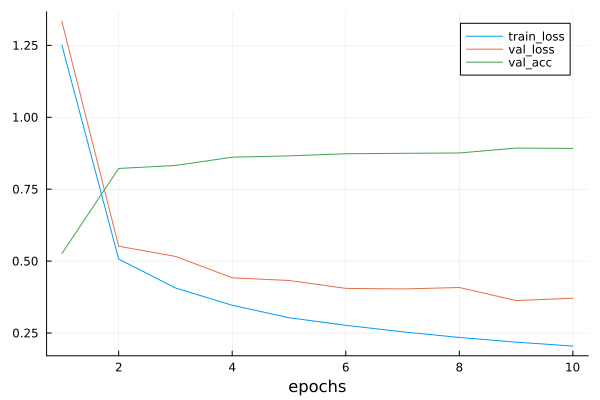

In [289]:
opt = Descent(0.05)
trainer = Trainer(model, data, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
d2lai.fit(trainer);

1